### Namibian power network generated from PyPSA-Earth-Sec - an open energy system optimization model

scenario configuration options : optimistic, realistic, conservative

References : 

For more information on the model, refer to the following sources.

[pypsa-earth-sec](https://github.com/pypsa-meets-earth/pypsa-earth-sec) on GitHub.

check [documentation](https://github.com/pypsa-meets-earth/documentation) for [pypsa-earth](https://github.com/pypsa-meets-earth/pypsa-earth) relation information.

see [pypsa-meets-earth](https://github.com/pypsa-meets-earth), 2023) project on GitHub. 


### Import packages

In [13]:
#Import packages
import os
import sys
import logging
import pypsa
import yaml
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
import cartopy.feature as cfeature

from scipy.sparse import csgraph
from itertools import product
import re

from shapely.geometry import Point, LineString
import shapely, shapely.prepared
from shapely.wkt import loads
from shapely.validation import make_valid

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)
#for solved network plot

from matplotlib.patches import Circle, Ellipse
from matplotlib.legend_handler import HandlerPatch
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches
plt.style.use("bmh")

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid", font_scale=1)

### Node query

In [14]:
n = pypsa.Network("../../pypsa-earth-sec/results/GADM7/postnetworks/elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_1export.nc") # keep the .nc file in same directory as the script
print("\n #### energy system network snapshot from "+ str(n.snapshots[0]) + " till " + str(n.snapshots[-19]))

c = n.buses
g = n.generators
g_t = n.generators_t

INFO:pypsa.io:Imported network elec_s_30_ec_lc1.0_Co2L_3H_2030_0.076_NZ_1export.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores



 #### energy system network snapshot from 2013-01-01 00:00:00 till 2013-12-29 15:00:00


In [19]:
n.stores_t['e']['co2 atmosphere'].max()

9795034.401134504

/home/raj08555/.conda/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


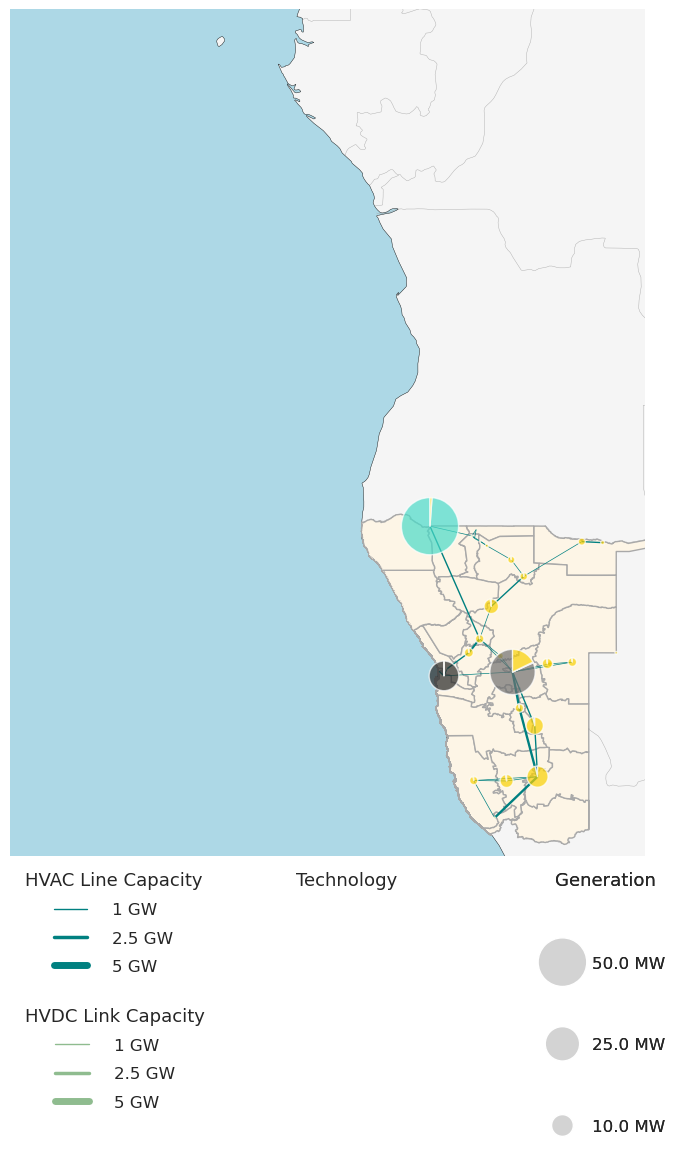

In [66]:
%run -i ../functions/helper_functions.ipynb
n.links.drop(
        n.links.index[(n.links.carrier != "DC") & (n.links.carrier != "B2B")],
        inplace=True,
    )
plot_network(n)
#n.plot()

In [65]:
n.carriers

,co2_emissions,color,nice_name,max_growth,max_relative_growth
Carrier,,,,,
offwind-ac,0.000,#6895dd,Offshore Wind (AC),inf,0.0
OCGT,0.187,#d35050,Open-Cycle Gas,inf,0.0
oil,0.248,#262626,Oil,inf,0.0
lignite,0.334,#9e5a01,Lignite,inf,0.0
coal,0.354,#707070,Coal,inf,0.0
nuclear,0.000,#ff9000,Nuclear,inf,0.0
onwind,0.000,#235ebc,Onshore Wind,inf,0.0
CCGT,0.187,#b20101,Combined-Cycle Gas,inf,0.0
geothermal,0.026,#ba91b1,Geothermal,inf,0.0


In [14]:

# =============================================================================
# #Node with highest solar installable capacity
# =============================================================================
solar_gen = g.filter(regex='solar$', axis=0)
solar_gen = solar_gen[['bus','p_nom_max', 'p_nom_opt', 'p_nom', 'p_max_pu']]
s_max = solar_gen['p_nom_max'].max()
bus = solar_gen.loc[solar_gen['p_nom_max']==s_max]
print("\n \n Highest maximum installable capacity node:")
print(bus[["bus", "p_nom_max"]])


 
 Highest maximum installable capacity node:
                       bus      p_nom_max
Generator                                
NA.1_1_AC solar  NA.1_1_AC  502199.098195


In [15]:
# =============================================================================
# #Node with highest wind installable capacity
# =============================================================================
wind_gen = g.filter(regex='wind$', axis=0)
wind_gen = wind_gen[['bus','p_nom_max', 'p_nom_opt', 'p_nom', 'p_max_pu']]
s_max = wind_gen['p_nom_max'].max()
bus = wind_gen.loc[wind_gen['p_nom_max']==s_max]
print(bus[["bus", "p_nom_max"]])

                        bus      p_nom_max
Generator                                 
NA.1_1_AC onwind  NA.1_1_AC  326748.293607


In [16]:

# =============================================================================
# #Node with highest solar installed
# =============================================================================
solar_gen = g.filter(regex='solar$', axis=0)
s_max = solar_gen['p_nom_opt'].max()
bus = solar_gen.loc[solar_gen['p_nom_opt']==s_max]
print("\n \n maximum installed capacity node:")
print(bus[["bus", "p_nom_opt"]])


 
 maximum installed capacity node:
                       bus    p_nom_opt
Generator                              
NA.3_1_AC solar  NA.3_1_AC  3416.900117


In [17]:

# =============================================================================
# #Node with highest wind installed
# =============================================================================
wind_gen = g.filter(regex='wind$', axis=0)
w_max = wind_gen['p_nom_opt'].max()
bus = wind_gen.loc[wind_gen['p_nom_opt']==w_max]
print("\n \n maximum installed capacity node:")
print(bus[["bus", "p_nom_opt"]])


 
 maximum installed capacity node:
                        bus  p_nom_opt
Generator                             
NA.1_1_AC onwind  NA.1_1_AC   1.260305


In [18]:

# =============================================================================
# #Max Generated solar power
# =============================================================================
p_max_pu = g_t['p']
x = p_max_pu.filter(regex='solar$', axis=1)
print('\n \n maximum solar energy is generated at node \n ' + 
      str(x.sum(axis=0).idxmax()) + ' is ' + str(x.sum(axis=0).max()*24) + ' MWh')


 
 maximum solar energy is generated at node 
 NA.3_1_AC solar is 973474.8738100685 MWh


In [19]:
# =============================================================================
# #Max generated wind power
# =============================================================================
p_max_pu = g_t['p']
y = p_max_pu.filter(regex='wind$', axis=1)
print('\n \n maximum wind energy generated at node \n' + 
      str(y.sum(axis=0).idxmax()) + ' is ' + str(y.sum(axis=0).max()*24) + ' MWh')


 
 maximum wind energy generated at node 
NA.1_1_AC onwind is 369.0821821067964 MWh


### Timestep Query

In [20]:

# =============================================================================
# # timestep with highest solar generation
# =============================================================================
solar_gen_max = g_t['p'].filter(regex='solar$', axis=1).max()
solar_gen_max_t = g_t['p'].filter(like=solar_gen_max.idxmax(), axis=1).idxmax()
print("\n \n Highest solar generation timestep: \n")
print(str(solar_gen_max_t[0]) +"   "+ str(solar_gen_max.max()*24) + " MWh")

# =============================================================================
# # timestep with lowest solar generation
# =============================================================================
solar_gen_min = g_t['p'].filter(regex='solar$', axis=1).min()
solar_gen_min_t = g_t['p'].filter(like=solar_gen_min.idxmin(), axis=1).idxmin()
print("\n \n Lowest solar generation timestep: \n")
print(str(solar_gen_min_t[0]) +"   "+ str(solar_gen_min.min()*24) + " MWh")



 
 Highest solar generation timestep: 

2013-10-28 00:00:00   18607.942317280227 MWh

 
 Lowest solar generation timestep: 

2013-11-15 00:00:00   3.4817682205030622 MWh


In [21]:

# =============================================================================
# # timeste with highest wind capacity
# =============================================================================
# =============================================================================
wind_gen_max = g_t['p'].filter(regex='wind$', axis=1).max()
wind_gen_max_t = g_t['p'].filter(like=wind_gen_max.idxmax(), axis=1).idxmax()
print("\n \n Highest wind generation timestep: \n")
print(str(wind_gen_max_t[0]) +"   "+ str(wind_gen_max.max()*24) + " MWh")

# =============================================================================
# # timestep with lowest wind generation
# =============================================================================
wind_gen_min = g_t['p'].filter(regex='wind$', axis=1).min()
wind_gen_min_t = g_t['p'].filter(like=wind_gen_min.idxmin(), axis=1).idxmin()
print("\n \n Lowest solar generation timestep: \n")
print(str(wind_gen_min_t[0]) +"   "+ str(wind_gen_min.min()*24) + " MWh")


 
 Highest wind generation timestep: 

2013-05-01 00:00:00   11.601014692695003 MWh

 
 Lowest solar generation timestep: 

2013-12-03 00:00:00   0.000887697003254369 MWh


In [22]:
#=============================================================================

# =============================================================================
# # timestep with highest demand overall
# =============================================================================
load = n.loads_t['p']
load_max = load.filter(like=load.max().idxmax(), axis=1)

print("\n \n highest demand overall timestep:")
print(str(load_max.idxmax().max()) +"   " + str(load_max.max().max()*24) + ' MWh')
#=============================================================================

# =============================================================================
# # timestep with lowest demand overall
# =============================================================================
load_min = load.filter(like=load.min().idxmin(), axis=1)

print("\n \n lowest demand overall timestep:")
print(str(load_min.idxmin().min()) +"   " + str(load_min.min().min()*24) + ' MWh')



 
 highest demand overall timestep:
2013-08-29 00:00:00   24657.637196847478 MWh

 
 lowest demand overall timestep:
2013-01-01 00:00:00   -10932.713140890603 MWh


### Node-demand

In [23]:

# =============================================================================
# #Node with Largest electrolyzer capacity
# =============================================================================

print("\n \n Largest electrolyzer capacity node:")

print(n.stores.filter(like='H2', axis=0)['e_nom_opt'].idxmax())
print(n.stores.filter(like='H2', axis=0)['e_nom_opt'].max())

# =============================================================================
# #Node with Smallest electrolyzer capacity
# =============================================================================

print("\n \n Smallest electrolyzer capacity node:")

print(n.stores.filter(like='H2', axis=0)['e_nom_opt'].idxmin())
print(n.stores.filter(like='H2', axis=0)['e_nom_opt'].min())



 
 Largest electrolyzer capacity node:
H2 export store
79.1753658127024

 
 Smallest electrolyzer capacity node:
NA.12_1_AC H2 Store
0.07186291079046088


In [24]:

# =============================================================================
# #Node with Largest direct air capture capacity
# =============================================================================

print("\n \n Largest direct air capture capacity node:")

print(n.stores.filter(like='co2 stor', axis=0)['e_nom_opt'].idxmax())
print(n.stores.filter(like='co2 stor', axis=0)['e_nom_opt'].max())

# =============================================================================
# #Node with Smallest direct air capture capacity
# =============================================================================

print("\n \n Smallest direct air capture capacity node:")

print(n.stores.filter(like='co2 stor', axis=0)['e_nom_opt'].idxmin())
print(n.stores.filter(like='co2 stor', axis=0)['e_nom_opt'].min())



 
 Largest direct air capture capacity node:
NA.1_1_AC co2 stored
27.98372741965556

 
 Smallest direct air capture capacity node:
NA.10_1_AC co2 stored
26.745782616972186


In [25]:

# =============================================================================
# #Node with Largest overall land transport demand (EV)
# =============================================================================
load = n.loads_t['p']
print("\n \n Largest overall land transport demand (EV) node:")
print(load.filter(like='land transport EV', axis=1).sum().idxmax())
print(load.filter(like='land transport EV', axis=1).sum().max()*24)



 
 Largest overall land transport demand (EV) node:
NA.12_1_AC land transport EV
45542.866570978054


In [26]:

# =============================================================================
# #Node with Largest overall land transport demand (Fuel cell) node
# =============================================================================

print("\n \n Largest overall land transport demand (Fuel cell) node:")
print(load.filter(like='land transport fuel cell', axis=1).sum().idxmax())
print(load.filter(like='land transport fuel cell', axis=1).sum().max()*24)


 
 Largest overall land transport demand (Fuel cell) node:
NA.12_1_AC land transport fuel cell
4711.328677140282


In [27]:

# =============================================================================
# #Node with Highest aggregate hydro generation node
# =============================================================================

print("\n \n Highest aggregate hydro generation node")
#print(n.storage_units_t['p'].filter(like='hydro', axis=1).sum().idxmax())
print(n.storage_units_t['p'].filter(like='hydro', axis=1).sum().max()*24)


 
 Highest aggregate hydro generation node
nan


In [28]:

# =============================================================================
# #Node with Highest h2 demand for industry
# =============================================================================

print("\n \n Highest h2 demand for industry node:")
print(load.filter(like='H2 for industry', axis=1).sum().idxmax())
print(load.filter(like='H2 for industry', axis=1).sum().max()*24)


 
 Highest h2 demand for industry node:
NA.10_1_AC H2 for industry
0.0


## Node pipeline

In [29]:

# =============================================================================
# #Largest capacity pipeline
# =============================================================================
print("\n \n Largest capacity pipeline:")
print(n.links.filter(like='pipeline', axis=0).p_nom_opt.idxmax())
print(n.links.filter(like='pipeline', axis=0).p_nom_opt.max())

# =============================================================================
# # 3rd Largest capacity pipeline
# =============================================================================
print("\n \n 3rd Largest capacity pipeline:")
print(n.links.filter(like='pipeline', axis=0).nlargest(3,'p_nom_opt').index[2])
print(n.links.filter(like='pipeline', axis=0).nlargest(3,'p_nom_opt').p_nom_opt.iloc[2])

# =============================================================================
# #Lowest capacity pipeline
# =============================================================================
print("\n \n Lowest capacity pipeline:")
print(n.links.filter(like='pipeline', axis=0).p_nom_opt.idxmin())
print(n.links.filter(like='pipeline', axis=0).p_nom_opt.min())



 
 Largest capacity pipeline:
CO2 pipeline NA.10_1_AC <-> NA.7_1_AC
0.058624210512690005

 
 3rd Largest capacity pipeline:
CO2 pipeline NA.10_1_AC <-> NA.11_1_AC
0.013792426211312332

 
 Lowest capacity pipeline:
CO2 pipeline NA.2_1_AC <-> NA.9_1_AC
0.002888492361018727
